# Firefighter Fatalities
This is a project investigating on-duty deaths of United States firefighters. The goal for this project is to examine the top causes of on-duty deaths for firefighters, which will hopefully lead to an increased understanding of what can be done to reduce their risk for these causes.

# About the data set
The data was downloaded from the U.S. Fire Administration website. Additional information on inclusion criteria for the dataset was obtained from the National Fire Protection Association (NFPA) website.

The data include all types of firefighters including volunteer, career, military, and prisoners. The fatalities included in this research are those resulting from traumatic injury, heart attack, or stroke while victims were on duty or within 24 hours of duty.

Illnesses or medical conditions other than heart attacks or strokes are not included in the study. Deaths due to cancer are not included in these data.

The data was downloaded from the U.S. Fire Administration website. It includes all recorded on-duty deaths 

# Acknowledgements 
This project would not be possible without members of individual fire departments, chief fire officers, fire service organizations, the U.S. Fire Administration, the National Fire Protection Association, and the National Fallen Firefighters Foundation. 


In [1]:
#import packages 

library(tidyverse)
library(psych)
library(janitor)
library(lubridate)
library(dplyr)
library(knitr)
library(ggplot2)
library(readxl)


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘psych’


The following objects are masked from ‘package:ggplot2’:

    %+%, alpha



Attaching package: ‘janitor’


The following objects are masked from ‘package:stats’:

    chisq.test, fisher.test




In [2]:
#import the data

deaths = read_xlsx("/kaggle/input/firefighter-on-duty-fatalities/deaths.xlsx")


### Before we go any further, I want to randomly select 2 firefighters in the dataset and anknowledge / remember their sacrifice.

### Thank you to these firemen.


In [3]:
# grab a random sample-------------------------------------------------------------------------

deaths %>% 
  select(first_name, last_name, initial_summary ) %>% 
  sample_n(2)

first_name,last_name,initial_summary
<chr>,<chr>,<chr>
Harold,"Coons, Jr.","Fire Police Captain Coons responded to the scene of a serious 2-vehicle crash. Upon his arrival on the scene, Fire Police Captain Coons began the task of controlling traffic and protecting the emergency scene.As a medical helicopter arrived on the scene, Fire Police Captain Coons was seen to drop to one knee and then fall to the ground, the victim of a heart attack. ALS-level EMS care was initiated immediately by medical personnel who had arrived on the helicopter.Emergency medical care was continued by EMS personnel who had responded to the original crash, and Fire Police Captain Coons was transported to the hospital. It was later reported that Fire Police Captain Coons had been pronounced dead at the hospital.Fire Police Captain Coons had held his office for 25 years and was the chairman of the board of fire commissioners for his department at the time of his death. The driver of the vehicle responsible for the original crash was charged with driving while intoxicated and additional charges related to the death of Fire Police Captain Coons."
L.,Merrell,"Lieutenant Merrell was in command of a truck company responding with lights and siren to a still alarm. Lieutenant Merrell was riding in the right front seat of the apparatus, and he was not wearing a seat belt.The truck entered a four-way stop intersection and was broadsided by a pickup truck that ran the stop sign. Lieutenant Merrell was thrown from the cab and struck the pavement. Immediate medical care was provided by other firefighters and medical personnel, but Lieutenant Merrell was pronounced dead at the scene. The cause of death was listed as blunt head trauma. The truck company slowed prior to entering the intersection.Four other firefighters and nine civilians in two vehicles were injured. The still alarm turned out to be a false alarm. The Chicago Fire Department Commissioner was quoted as saying that Lieutenant Merrell could have survived the accident if he had been wearing a seat belt. The driver of the pickup was ticketed for speeding and failure to stop."


In [4]:
#clean the column names
deaths = deaths %>%
  clean_names(case = "snake")

In [5]:
#check the names
names(deaths)

[1] "initial_summary"        "first_name"             "last_name"             
 [4] "middle_name"            "age"                    "rank"                  
 [7] "classification"         "incident_date"          "date_of_death"         
[10] "cause_of_fatal_injury"  "nature_of_fatal_injury" "activity"              
[13] "emergency"              "duty"                   "property_type"         
[16] "memorial_fund_info"     "dept_name"              "dept_address_1"        
[19] "dept_address_2"         "dept_city"              "dept_state"            
[22] "dept_zip_code"

In [6]:
# separate the date into separate columns-------------------------------------------------------------------------

deaths <- deaths %>%
  mutate(date_of_death = ymd(date_of_death)) %>%
  mutate(year = year(date_of_death),
         month = month(date_of_death),
         day = day(date_of_death))

In [7]:
#remove the 9/11 firefighters and only consider 1991 and up
#this event is an outlier in our dataset and cause unwanted conclusions 
deaths = deaths %>% 
  filter(!(year == 2001 & month == 9 & day == 11)) %>% 
  filter(year > 1990)

In [8]:
#combine the smaller death types into an "other" category
deaths = deaths %>% 
  mutate(
    cause_of_fatal_injury = ifelse(cause_of_fatal_injury == "Assault", "Other",
                        ifelse(cause_of_fatal_injury == "Contact With", "Other",
                        ifelse(cause_of_fatal_injury == "Out of Air", "Other",
                        ifelse(cause_of_fatal_injury == "Unknown", "Other", cause_of_fatal_injury
                        ))))) %>% 
  mutate(cause_of_fatal_injury = ifelse(cause_of_fatal_injury == "Vehicle Collision - Includes Aircraft", "Vehicle/Aircraft Collision"
                                        , cause_of_fatal_injury ))

In [9]:
#create a subset to base my plots on
deathsgraph = deaths %>% 
  filter(year > 1990) %>% 
  group_by(cause_of_fatal_injury) %>% 
  summarise(
    count = n()
  ) %>% 
  mutate(total_count = sum(count),
         frequency = round((count / total_count) * 100))


In [10]:
print(deathsgraph)

# A tibble: 11 × 4
   cause_of_fatal_injury      count total_count frequency
   <chr>                      <int>       <int>     <dbl>
 1 Caught or Trapped            332        3189        10
 2 Collapse                      66        3189         2
 3 Exposure                     193        3189         6
 4 Fall                         115        3189         4
 5 Lost                          19        3189         1
 6 Other                        126        3189         4
 7 Stress/Overexertion         1509        3189        47
 8 Struck By                    455        3189        14
 9 Suicide                        6        3189         0
10 Vehicle/Aircraft Collision   326        3189        10
11 NA                            42        3189         1




### We can see that stress/overexertion is a huge contributor, followed by Vehicle/Aircraft Collision and Caught or Trapped.

### Stress/overexertion is typically some sort of caridac event, iincluding heart attacks. Keep in mind that the symptoms and death must occur with 24 hours of being on shift.

### Vehicle/Aircraft Collision is self explanatory. Driving to fire/rescue scenes can be a very dangerous and underlooked process. This dataset also includes many aircraft/helicopter crashes.

### Caught or Trapped typically indicates a firefighter who was trapped at a fire scene due to building collapse and could not escape or be rescued. 

### Now lets graph it to visualize the numbers 


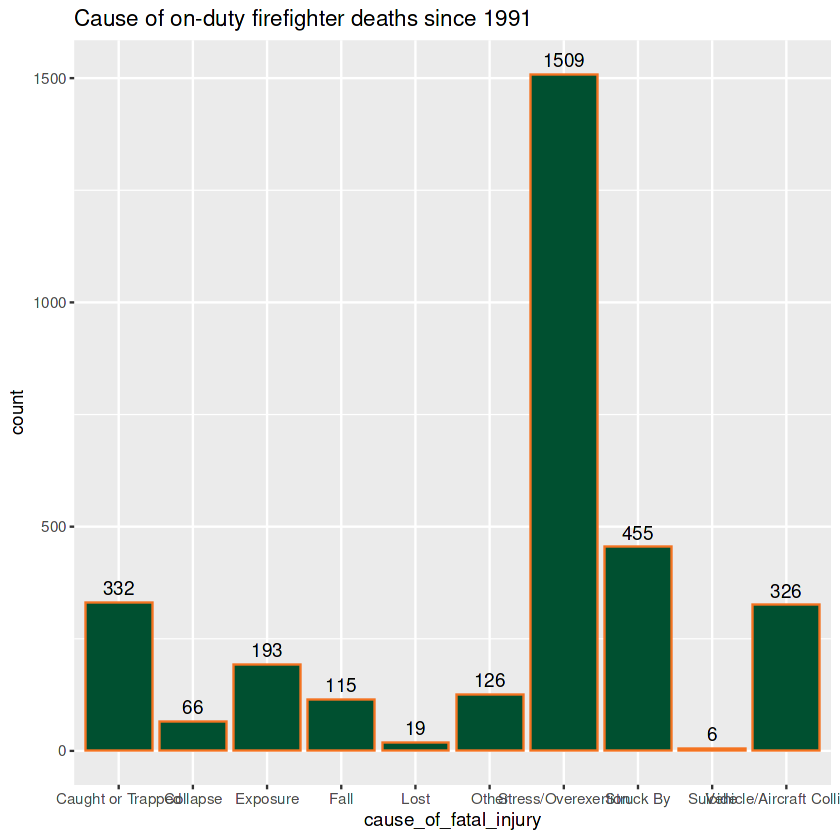

In [11]:

deathsgraph %>% 
  drop_na(cause_of_fatal_injury) %>%
  ggplot(aes(cause_of_fatal_injury, count)) +
  geom_bar(stat = "identity", position = "dodge",  color = "#f47321", fill = "#005030") +
  geom_text(aes(label = count), position = position_dodge(width = 0.9), vjust = -0.5) +
  labs(title = "Cause of on-duty firefighter deaths since 1991")



### Although the variable names are a little scrunched, we can see that Stress/Overexertion is causing a large amount of firefighter deaths while on-duty. It is ~ 47% of all deaths in the data set. Keep this in mind for our conclusion.

### Next, we will look at how the deaths are distributed by age groups, and dive further into the Stress/Overexertion variable by examining the age distribution.

In [12]:
#create age groups 
deaths = deaths %>% 
  mutate(age_cats = ifelse(age <= 44, "44 and under",
                           ifelse(age >= 45 & age < 55, "45-54",
                                  ifelse(age >= 55 & age < 65, "55-64", 
                                         ifelse(age >= 65, "65 and over", age)))))

In [13]:
#check out the numbers for each group
table(deaths$age_cats)


44 and under        45-54        55-64  65 and over 
        1334          841          562          346 

In [14]:
# graph deaths by age cats-------------------------------------------------------------------------
#create a subset to base my plots on
deathschart4 = deaths %>% 
  drop_na(age_cats) %>% 
  group_by(age_cats) %>% 
  summarize(
    count = n()
  ) %>% 
  mutate(total_count = sum(count),
         frequency = round((count / total_count) * 100))

In [15]:
print(deathschart4)

# A tibble: 4 × 4
  age_cats     count total_count frequency
  <chr>        <int>       <int>     <dbl>
1 44 and under  1334        3083        43
2 45-54          841        3083        27
3 55-64          562        3083        18
4 65 and over    346        3083        11


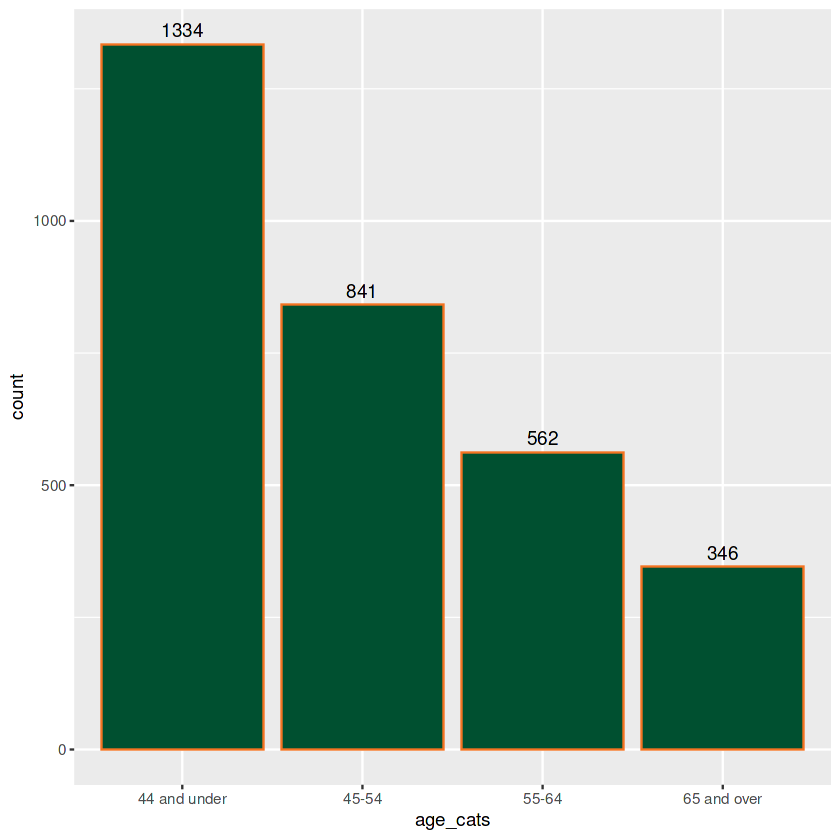

In [16]:
#plot it
deathschart4 %>%
  drop_na(age_cats) %>% 
  ggplot(aes(age_cats, count)) +
  geom_col(color = "#f47321", fill = "#005030")+
  geom_text(aes(label = count), position = position_dodge(width = 0.9), vjust = -0.5)

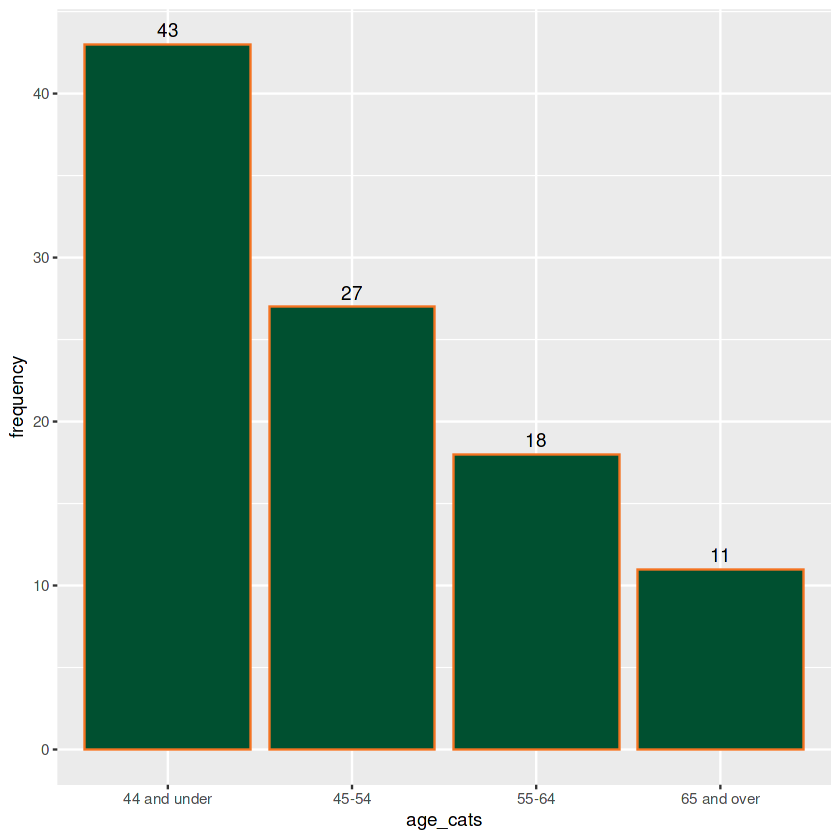

In [17]:
#chart with percentages 
deathschart4 %>%
  drop_na(age_cats) %>% 
  ggplot(aes(age_cats, frequency)) +
  geom_col(color = "#f47321", fill = "#005030") +
  geom_text(aes(label = frequency), position = position_dodge(width = 0.9), vjust = -0.5)




### Above you can see the percentage contribution of each age group into the dataset. 

### Now lets see if how this distribution looks when only applied to the stress/overexertion variable.

In [18]:
# graph cardiac deaths by age group-------------------------------------------------------------------------
deathschart5 = deaths %>% 
  filter(cause_of_fatal_injury == "Stress/Overexertion") %>% 
  drop_na(age_cats) %>% 
  group_by(age_cats) %>% 
  summarize(
    count = n()
  ) %>% 
  mutate(total_count = sum(count),
         frequency = round((count / total_count) * 100))

In [19]:
print(deathschart5)

# A tibble: 4 × 4
  age_cats     count total_count frequency
  <chr>        <int>       <int>     <dbl>
1 44 and under   352        1457        24
2 45-54          494        1457        34
3 55-64          364        1457        25
4 65 and over    247        1457        17


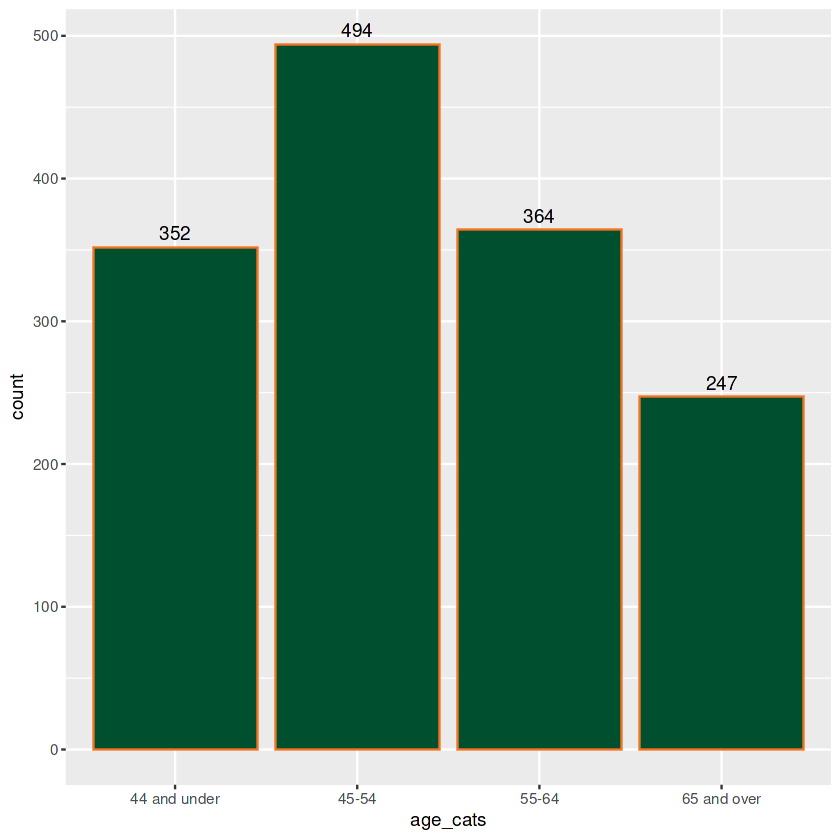

In [20]:
deathschart5 %>% 
  drop_na(age_cats) %>% 
  ggplot(aes(age_cats, count)) +
  geom_col(color = "#f47321", fill = "#005030")+
  geom_text(aes(label = count), position = position_dodge(width = 0.9), vjust = -0.5)

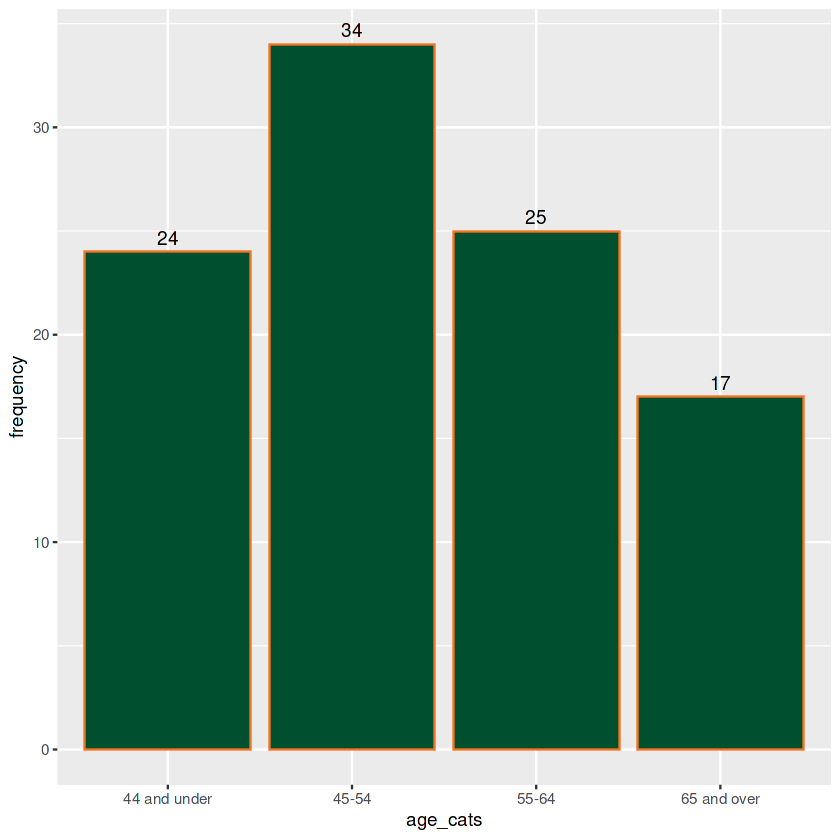

In [21]:

deathschart5 %>%
  drop_na(age_cats) %>% 
  ggplot(aes(age_cats, frequency)) +
  geom_col(color = "#f47321", fill = "#005030") +
  geom_text(aes(label = frequency), position = position_dodge(width = 0.9), vjust = -0.5)

### You can see that age is a significant contributing factor to stress/overexertion deaths. 

### This is expected, as in the general population as age increases as does likelihood for cardiac events. 

### Although I might expect these numbers to be less dramatic. Age is also coorelated to rank, and with increase in rank comes an increase in sedentary time and less expectations to perform the intense labor typically seen at more entry levels ranks.

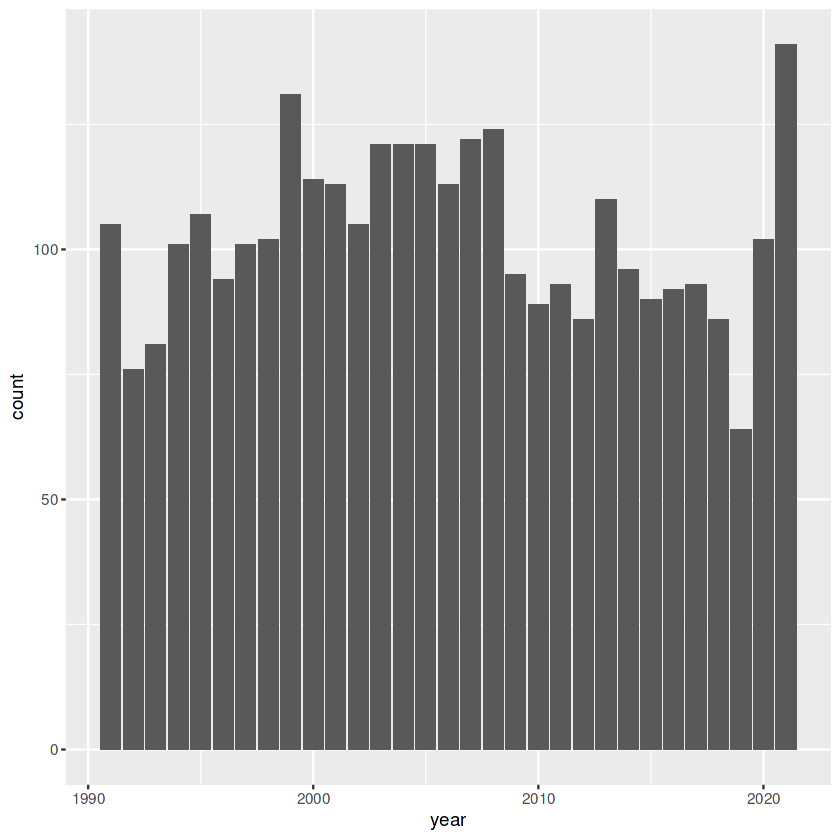

In [22]:
# graph deaths by year-------------------------------------------------------------------------

deaths %>% 
  ggplot(aes(year)) +
  geom_bar()




### On-duty fatalities remain relatively steady over time at ~100 deaths per year. This is despite a growing firefighter workforce.

In [23]:
deaths %>% 
  drop_na(year) %>% 
  group_by(year) %>%  
  summarize(
    count = n(),
  ) %>% 
  mutate(
    mean = mean(count)
  )

year,count,mean
<dbl>,<int>,<dbl>
1991,105,102.871
1992,76,102.871
1993,81,102.871
1994,101,102.871
1995,107,102.871
1996,94,102.871
1997,101,102.871
1998,102,102.871
1999,131,102.871




### Now lets lets take a look at what types of firefighters are in this dataset

In [24]:
# deaths by type of firefighter-------------------------------------------------------------------------
deaths %>% 
  drop_na(classification) %>% 
  group_by(classification) %>% 
  summarise(
    count = n(),
    mean_age = mean(age, na.rm = T)
  ) %>% 
  mutate(total_count = sum(count),
         frequency = round((count / total_count) * 100))

classification,count,mean_age,total_count,frequency
<chr>,<int>,<dbl>,<int>,<dbl>
Career,1234,44.02403,3139,39
Industrial,5,46.60000,3139,0
Paid-on-Call,48,48.22917,3139,2
Part-Time (Paid),39,47.69231,3139,1
Volunteer,1632,49.01509,3139,52
Wildland Contract,68,45.67188,3139,2
Wildland Full-Time,62,37.83607,3139,2
Wildland Part-Time,51,29.52941,3139,2





### Lets break this down further, and see if either Career or Volunteers show increaced vunerability to the main cause of death in the dataset, cardiac events.

In [25]:
# cardiac deaths by type of firefighter-------------------------------------------------------------------------
deaths %>% 
  filter(cause_of_fatal_injury == "Stress/Overexertion") %>% 
  group_by(classification) %>% 
  summarise(
    count = n()
  ) %>% 
  mutate(total_count = sum(count),
         frequency = round((count / total_count) * 100))


classification,count,total_count,frequency
<chr>,<int>,<int>,<dbl>
Career,493,1509,33
Industrial,4,1509,0
Paid-on-Call,32,1509,2
Part-Time (Paid),21,1509,1
Volunteer,900,1509,60
Wildland Contract,6,1509,0
Wildland Full-Time,14,1509,1
Wildland Part-Time,6,1509,0
NA,33,1509,2


### Lets dive even deeper to see if there is a significant difference between Career or Volunteers.

### But first lets explore the Stress/Overexaustion option in the cause of death variable. I want to understand what % of these deaths are heart attacks.

In [26]:
# what % of Stress/Overexertion are heart attacks?-------------------------------------------------------------------------

deaths %>% 
  filter(cause_of_fatal_injury == "Stress/Overexertion") %>% 
  drop_na(nature_of_fatal_injury) %>% 
  group_by(nature_of_fatal_injury) %>% 
  summarise(
    count = n()
  ) %>% 
  mutate(total_count = sum(count),
         frequency = round((count / total_count) * 100))

nature_of_fatal_injury,count,total_count,frequency
<chr>,<int>,<int>,<dbl>
Asphyxiation,2,1508,0
Cerebrovascular Accident,86,1508,6
Electrocution,2,1508,0
Heart Attack,1380,1508,92
Heat Exhaustion,8,1508,1
Other,25,1508,2
Trauma,2,1508,0
Unknown,3,1508,0


### So moving forward I will refer to the Stress/Overexertion cases as cardiac events or heart attacks.

In [27]:
# are volunteers more likely to have heart attacks than career?-------------------------------------------------------------------------
#create a subset of the data and create a heart attack variable - this will be our main outcome 
deaths_heartattacks = deaths %>% 
  select(cause_of_fatal_injury, age, classification) %>% 
  filter(classification == "Career" | classification == "Volunteer") %>% 
  mutate(heart_attack = ifelse(cause_of_fatal_injury == "Stress/Overexertion", 1, 0))

In [28]:
deaths_heartattacks %>% 
  group_by(classification) %>% 
  summarise(
    count = n(),
    heartattacks = sum(heart_attack, na.rm = T),
    age = mean(age, na.rm = T)
  ) %>% 
  mutate(total_count = sum(count),
         frequency = round((count / total_count) * 100))

classification,count,heartattacks,age,total_count,frequency
<chr>,<int>,<dbl>,<dbl>,<int>,<dbl>
Career,1234,493,44.02403,2866,43
Volunteer,1632,900,49.01509,2866,57


In [29]:
#binomial linear regression test
glm99 = glm(heart_attack ~ classification + age, family = "binomial", data = deaths_heartattacks)


In [30]:
summary(glm99)


Call:
glm(formula = heart_attack ~ classification + age, family = "binomial", 
    data = deaths_heartattacks)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.4241  -0.9880  -0.5425   1.0324   2.0215  

Coefficients:
                         Estimate Std. Error z value Pr(>|z|)    
(Intercept)             -3.157609   0.162938 -19.379  < 2e-16 ***
classificationVolunteer  0.339797   0.084329   4.029 5.59e-05 ***
age                      0.062655   0.003323  18.853  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 3825.5  on 2759  degrees of freedom
Residual deviance: 3333.6  on 2757  degrees of freedom
  (106 observations deleted due to missingness)
AIC: 3339.6

Number of Fisher Scoring iterations: 4


### In this dataset, volunteer firefighters are significantly more likely to have died due to a cardiac event than career.

# Conclusions 

Firefighting is an inherintely dangerous occupation and firefighters face deadly situations on a nearly daily basis. They are expected to be willing to put their own lives at risk at any time in order to serve and protect others. These data show us the unfortunate reality of that expectation, but also helps us to understand the top contributing causes to firefighter fatalies. Understanding these can help us to target health and safety improvement programs  in order to reduce the risk of these top contributors.

It is clear that cardiac events are the most significant contributing factor to on-duty deaths, and that age increases the likilihood for this outcome. While cardiac events have many additional risk factors that are not available in these data, we can still learn from this information. Reducing risk for cardiac events is critical, especially as age increases. This can be done in many ways, such as improving diet quality, increasing exercise, reducing excess body weight, and reducing / eliminating alcohol consumption.

Vehicle/Aircraft Collision was also a significant contributor, potentially underscoring the need for additonal saftey measures concerning transport. Firefighters spend large amounts of time on the road driving to and from various call responses, making them statistically much more likely to be in an traffic accident. Ideally, driving safety classes should be available and prioritized for anyone who will be driving to calls. Highly rated crash safety features could also be made a top priority when purchasing new vehicles. 